In [ ]:
import sys
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/AML KAGGLE')
!pwd

if 'COLAB_TPU_ADDR' not in os.environ: 
  print('Not connected to TPU') 
else: 
  print("Connected to TPU") 
from IPython.display import clear_output

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/AML KAGGLE
Not connected to TPU


In [ ]:
IS_COLAB_BACKEND = 'COLAB_GPU_ADDR' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user() 

Creating a bucket, make sure it doesn't already exist.

# Dependencies

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math 
import scipy
import shutil
import cv2

import warnings
from collections import Counter,defaultdict
import time
from datetime import datetime

import pickle
from sklearn.model_selection import train_test_split
from collections import Counter 
from sklearn.metrics import confusion_matrix,f1_score
#plotting
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [ ]:
# DEEPLEARNING TENSORFLOW
#!pip install tensorflow==1.13.1
#!pip install scipy==1.2.0
# DEEPLEARNING TENSORFLOW
#!pip install keras==2.2.4 # 1.2.1
#!kill -9 -1

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2


from tensorflow.keras import regularizers
from tensorflow.keras import models

!pip install livelossplot    # run this if u get ERROR
from livelossplot import PlotLossesKeras

#PRE-TRAINED MODEL IMage-NET
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

import tensorflow.keras.backend as K
# clear output

clear_output()

In [ ]:
print("Keras current version {}".format(keras.__version__))
print("Tensorflow current version {}".format(tf.__version__))
print("Tensorflow current version {}".format(scipy.__version__))
# this one is from github, extended ImageDataGenerator
import image_gen_extended as ext

Keras current version 2.2.4-tf
Tensorflow current version 1.15.0
Tensorflow current version 1.3.3


Using TensorFlow backend.


Setting up TPU

In [ ]:
import pprint # for pretty printing our device stats

if 'COLAB_TPU_ADDR' not in os.environ:
    print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print ('TPU address is', tpu_address)

    with tf.compat.v1.Session(tpu_address) as session:
      devices = session.list_devices()

    print('TPU devices:')
    pprint.pprint(devices)

#Paths and hyper parameters

In [ ]:
# Paths: 
path = "/content/gdrive/My Drive/AML KAGGLE/train_labels.csv" 
path_train = "/content/gdrive/My Drive/AML KAGGLE/train_set"
path_test = "/content/gdrive/My Drive/AML KAGGLE/test_set"
# Paths split data:
source = path_train
path_train_l = "/content/gdrive/My Drive/AML KAGGLE/train_set_l"
path_validate_l = "/content/gdrive/My Drive/AML KAGGLE/validate_set_l"

# Hyperparams
IMAGE_SIZE = 144   
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
BATCH_SIZE = 64
EPOCHS = 20
BATCH_SIZE = 64
##TEST_SIZE = 30

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,3)

# Data augmentation
#define readers, one for test one for train with augmentation parameters 
data_generator = ext.ImageDataGenerator(rescale=1./255,     # ext
    shear_range=0.1,
    rotation_range = 0,
    zoom_range=0.15,
    width_shift_range=0.25,
		height_shift_range=0.1,
    horizontal_flip=True,
   #validation_split = 0.15,   # doesnt  work with te ext. version, so we have to do it manual
    fill_mode='nearest')

train_datagen = ImageDataGenerator(rescale=1./255,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          zoom_range=0.3,
                                          fill_mode='nearest' #, preprocessing_function = preprocess_input
                                          )
test_datagen = ImageDataGenerator(
    rescale=1/255,
)
# Adding extra config
data_generator.config['random_crop_size'] = (IMAGE_SIZE, IMAGE_SIZE)
data_generator.set_pipeline([ext.random_crop, preprocess_input, ext.center_crop, ext.standardize])
print("Total amount in the training set equals: {} images".format(str(len(os.listdir(path_train)))))

Total amount in the training set equals: 30612 images


In [ ]:
 #####
labels = pd.read_csv(path)
'''
new = labels["img_name"].str.split(".", n = 1, expand = True) 
labels["img_name"]= new[0]
'''
freq_ = pd.DataFrame.from_dict(Counter(sorted(labels['label'])), orient='index').reset_index().rename(columns ={'index':'Class', 0:'Frequency'})
fig = px.bar(freq_.dropna(), x='Class', y='Frequency')
## fig.show()
# the distribution is too uneven to make any statistical inference !!!
print("Total amount in the training set equals: {} images".format( sum(freq_['Frequency'])))

Total amount in the training set equals: 30612 images


##READ images and Initiate splits (train-validation-test)

##Reading images

The code below is an alternative to the ImageDataGenerator(validation_split). For visualization and if you are using the ext.ImageDataGenerator

In [ ]:
# make a dictionary, label = dict.keys
dictionary_train_all = {k: g["img_name"].tolist() for k,g in labels.groupby("label")}

# select a portion of every key to go to the validation set. 
np.random.seed(5)  # set seed to 10
portion = 0.15  # 20 %
dictionary_validation = {}
dictionary_train = {}
for key in dictionary_train_all.keys():
    dictionary_validation[key] = set(np.random.choice(list(dictionary_train_all.get(key)), np.rint(portion * len(dictionary_train_all.get(key))).astype(int))) # make sure to set() it otherwise it will not iterate properly. DIFF in {} amd []
    dictionary_train[key] = set(dictionary_train_all[key]) - set(dictionary_validation[key])
# making the frequency tables
frequency_val = {k:len(v) for k, v in dictionary_validation.items()}
frequency_val = pd.DataFrame.from_dict((frequency_val), orient='index').reset_index().rename(columns ={'index':'Class', 0:'Frequency'})
frequency_train ={k:len(v) for k, v in dictionary_train.items()}
frequency_train = pd.DataFrame.from_dict((frequency_train), orient='index').reset_index().rename(columns ={'index':'Class', 0:'Frequency'})                                                                                      

In [ ]:
list(dictionary_validation[1]).index('train_15061.jpg')

12

Define a function that moves the validation set out of the training set//another directory and group tain

In [ ]:
def split_train_folder (source,path_train_l,path_validate_l):
  ''' GIven a folder named 'train_set', it takes all images and it copies them to another folders with designated split'''
  if not os.path.exists(path_train_l):  
    for key,value in dictionary_train.items():
      if not os.path.exists(os.path.join(path_train_l,str(key))):
        os.makedirs(os.path.join(path_train_l,str(key)))
        for j in list(value):
          shutil.copy(source+ "/" + j, os.path.join(path_train_l,str(key)))
      else:
        '''
        shutil.rmtree(os.path.join(path_train_l,str(key)))  # delete old one
        os.makedirs(os.path.join(path_train_l,str(key))) # make new one
        '''
        pass
  else:
    print("The folder {} already exists, no need to run this again".format(path_train_l))
  if not os.path.exists(path_validate_l):
    for key,value in dictionary_validation.items():
      if not os.path.exists(os.path.join(path_validate_l,str(key))):
        os.makedirs(os.path.join(path_validate_l,str(key)))
        for j in list(value):
          shutil.copy(source+ "/" + j, os.path.join(path_validate_l,str(key)))
      else:
        '''
        shutil.rmtree(os.path.join(path_validate_l,str(key)))  # delete old one
        os.makedirs(os.path.join(path_validate_l,str(key))) # make new one
        '''
        pass
  else:
    print("The folder {} already exists, no need to run this again".format(path_validate_l))

def move_back_original (source,  dest):
  for class_ in os.listdir(source):
    for img in os.listdir(os.path.join(source,class_)):
          shutil.move(os.path.join(source,class_) + "/"+ img, dest)
  print("Total amount in the training set equals: {} images".format(len(os.listdir(dest))))

In [ ]:
t_0 = datetime.now()
# split_train_folder(source,path_train_l,path_validate_l)   # uncomment to run split
t_1 = datetime.now()
delta = t_1 - t_0
print("This took {}".format(delta)) 

 ## takes approx 6 hours.

This took 0:00:00.000041


Check whether the split is done correctly: IF the equality is satisfied

In [ ]:
print(len(os.listdir(os.path.join(path_train_l,"33"))) == len(list(dictionary_train[33])))
print(len(os.listdir(os.path.join(path_validate_l,"20")))==len(list(dictionary_validation[20])))

True
True


##**Setting up image reader**  Here I dont use data_generator, because of an error that needs to be fixed

In [ ]:
t_0 = time.time()

# Data preparation
train_generator = train_datagen.flow_from_directory(
    directory=path_train_l,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode="categorical",
    #subset='training',
    seed=5) # set as training dat
validation_generator = test_datagen.flow_from_directory(
    directory=path_validate_l,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = 1,  # set to 1 if u want to use it as a test set.
    class_mode="categorical",
    seed=5) # set as training dat
t_1 = time.time()
print((t_1 - t_0)/60) # duration in minutes

Found 26347 images belonging to 80 classes.
Found 4265 images belonging to 80 classes.
0.8799057682355245


In [ ]:
train_generator.class_indices  # something is wrong here, change in prediction section

{'1': 0,
 '10': 1,
 '11': 2,
 '12': 3,
 '13': 4,
 '14': 5,
 '15': 6,
 '16': 7,
 '17': 8,
 '18': 9,
 '19': 10,
 '2': 11,
 '20': 12,
 '21': 13,
 '22': 14,
 '23': 15,
 '24': 16,
 '25': 17,
 '26': 18,
 '27': 19,
 '28': 20,
 '29': 21,
 '3': 22,
 '30': 23,
 '31': 24,
 '32': 25,
 '33': 26,
 '34': 27,
 '35': 28,
 '36': 29,
 '37': 30,
 '38': 31,
 '39': 32,
 '4': 33,
 '40': 34,
 '41': 35,
 '42': 36,
 '43': 37,
 '44': 38,
 '45': 39,
 '46': 40,
 '47': 41,
 '48': 42,
 '49': 43,
 '5': 44,
 '50': 45,
 '51': 46,
 '52': 47,
 '53': 48,
 '54': 49,
 '55': 50,
 '56': 51,
 '57': 52,
 '58': 53,
 '59': 54,
 '6': 55,
 '60': 56,
 '61': 57,
 '62': 58,
 '63': 59,
 '64': 60,
 '65': 61,
 '66': 62,
 '67': 63,
 '68': 64,
 '69': 65,
 '7': 66,
 '70': 67,
 '71': 68,
 '72': 69,
 '73': 70,
 '74': 71,
 '75': 72,
 '76': 73,
 '77': 74,
 '78': 75,
 '79': 76,
 '8': 77,
 '80': 78,
 '9': 79}

In case you use TPU you wont be able to use the generators , so to load the data manually into RAM use : 

Lets save the data in pickle format: 


##*MODEL*

### LOKAAL

In [ ]:
''' Run first the generator code parg: "Setting up image reader", 
and everything before "Read image and initial split" '''
tf.keras.backend.clear_session()

base_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, 
                        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),pooling = 'avg')
base_InceptionV3.trainable = False

model = Sequential()
model.add(base_InceptionV3)

model.add(Flatten())
model.add(Dense(256 , activation='relu', name='Dense_Intermediate'))
model.add(Dropout(0.1, name='Dropout_Regularization'))

opt = SGD(lr=.01, momentum=.9)  # stochastic gradient descent
model.add(Dense(80, activation='sigmoid', name='Output',kernel_regularizer=l2(.0005)))
#model.summary()
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='model33{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1,save_best_only=False)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule) # non-TPU

result = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    validation_steps=67, #4265/64
                    steps_per_epoch=412,    #
                    verbose=2
                   ,callbacks = [EarlyStopping(patience=3, restore_best_weights=True),ReduceLROnPlateau(patience=2),checkpointer]
)

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
# model.add(base_InceptionV3)
model.add(Conv2D(36, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(scale=False, center=True))
model.add(Conv2D(72, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(scale=False, center=True))
model.add(Conv2D(144, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(scale=False, center=True))
model.add(Conv2D(288, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2, name='Dropout'))
model.add(Flatten())
model.add(Dense(288, activation='relu'))

#model.add(Flatten())
#model.add(Dense(256 , activation='relu', name='Dense_Intermediate'))
model.add(Dropout(0.1, name='Dropout_Regularization'))

model.add(Dense(80, activation='softmax', name='Output',kernel_regularizer=l2(.0005)))

In [ ]:
model = load_model(filepath='model8.02-4.60.hdf5')

model.compile(optimizer =  tf.train.AdamOptimizer(learning_rate=1e-3, ), loss = 'categorical_crossentropy', metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='modelFF.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1,save_best_only=False)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule) # non-TPU

result = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    validation_steps=67, #4265/64
                    steps_per_epoch=412,    #
                    verbose=2
                   ,callbacks = [checkpointer]
)

### Trying other method than generator

In [ ]:
from os import listdir
from os.path import isfile, join
import matplotlib.image as img

def load_images(root):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        for img_name in imgs:
            img_arr = img.imread(join(root, subdir, img_name))
            img_arr = cv2.resize(img_arr,(IMAGE_SIZE,IMAGE_SIZE))
            all_imgs.append(img_arr)
            all_classes.append(subdir)
    return np.array(all_imgs), np.array(all_classes)

In [ ]:
# run once

t_0 = datetime.now()
X_test = []
img_name = []
root = path_test
for i in listdir(root):
  img_arr = img.imread(join(root,i))
  img_arr = cv2.resize(img_arr,(IMAGE_SIZE,IMAGE_SIZE))  
  X_test.append(img_arr)
  img_name.append(i)
t_1 = datetime.now()
delta = t_1 - t_0
print("This took {}".format(delta)) 

pickle_out = open("test_set_X.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()
df = pd.DataFrame(data={"img names order processed": img_name})
df.to_csv("img_order_loaded(hoort bij test_set-pickle).csv.csv", sep=',',index=False)

This took 0:00:32.454129


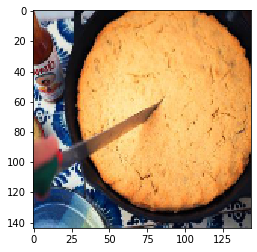

In [ ]:
plt.imshow(X_test[0])

In [ ]:

t_0 = datetime.now()
X_train, y_train = load_images(path_train_l)
t_1 = datetime.now()
delta = t_1 - t_0
print("This took {}".format(delta))

#SAVING DATA
# Save data
pickle_out = open("train_set_X.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()
pickle_out = open("train_set_y.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close() 

In [ ]:

t_0 = datetime.now()
X_test, y_test = load_images(path_validate_l, min_side=144)
# Save data
pickle_out = open("test_set_X.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()
pickle_out = open("test_set_y.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()
t_1 = datetime.now()
delta = t_1 - t_0
print("This took {}".format(delta)) 

###Experiment with TPU

In [ ]:
''' # for version tf 1.15.0 + 
tf.config.experimental_connect_to_host('grpc://' + os.environ['COLAB_TPU_ADDR'])
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver) 
'''

" # for version tf 1.15.0 + \ntf.config.experimental_connect_to_host('grpc://' + os.environ['COLAB_TPU_ADDR'])\nresolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])\ntf.tpu.experimental.initialize_tpu_system(resolver)\nstrategy = tf.distribute.experimental.TPUStrategy(resolver) \n"

ERROR at fit_generator: 
NotImplementedError: `fit_generator` is not supported for models compiled with tf.distribute.Strategy  !  BYPASS WITH FIT or use TF 1.13.1 if you use google TPU

In [ ]:
# USING FIT
base_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, 
                        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3) ,pooling = 'avg')
base_InceptionV3.trainable = False

model = Sequential()
model.add(base_InceptionV3)
model.add(Flatten())
model.add(Dense(256, activation='relu', name='Dense_Intermediate'))
model.add(Dropout(0.1, name='Dropout_Regularization'))


model.add(Dense(80, activation='softmax', name='Output'))
model.compile(optimizer = tf.train.AdamOptimizer(learning_rate=1e-3, ), loss = 'categorical_crossentropy', metrics = ['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# TPU
tf.logging.set_verbosity(tf.logging.DEBUG)
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(
            tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.7.199.66:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 17356328858269089244)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5607269943251311080)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16932652404789138166)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1

In [ ]:
#test 2
base_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),pooling = 'avg') #
base_InceptionV3.trainable = False
model = Sequential()
model.add(base_InceptionV3)
model.add(Flatten())
model.add(Dense(256, activation='relu', name='Dense_Intermediate'))
model.add(Dropout(0.1, name='Dropout_Regularization'))


model.add(Dense(80, activation='softmax', name='Output'))#,kernel_regularizer=l2(.0005)

#model.summary()
model.compile(optimizer = tf.train.AdamOptimizer(learning_rate=1e-3, ), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# TPU
tf.logging.set_verbosity(tf.logging.DEBUG)
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(
            tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))

INFO:tensorflow:Querying Tensorflow master (grpc://10.12.128.66:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2034897022145342977)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15899117371460686617)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15313611155220763879)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 662626835093488909)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 8434115266863027119)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/

In [ ]:
checkpointer = ModelCheckpoint(filepath='model1.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1,save_best_only=False)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
# lr_scheduler = LearningRateScheduler(schedule) # non-TPU

result = tpu_model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    validation_steps=67, #4265/64
                    steps_per_epoch=412,    #
                    verbose=2 
                  ,callbacks = [EarlyStopping(patience=3, restore_best_weights=True), checkpointer ]
        )


In [ ]:
# Normal , TEST TPU work
'''
model = Sequential([
  base_InceptionV3,
  Dense(80, activation='sigmoid',kernel_regularizer=l2(.0005))])
  '''
#base_model
tf.keras.backend.clear_session()

##base_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),pooling = 'avg')
##base_InceptionV3.trainable = False

model = Sequential()
# model.add(base_InceptionV3)
model.add(Conv2D(36, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(scale=False, center=True))
model.add(Conv2D(72, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(scale=False, center=True))
model.add(Conv2D(144, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(scale=False, center=True))
model.add(Conv2D(288, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2, name='Dropout'))
model.add(Flatten())
model.add(Dense(288, activation='relu'))

#model.add(Flatten())
#model.add(Dense(256 , activation='relu', name='Dense_Intermediate'))
model.add(Dropout(0.1, name='Dropout_Regularization'))

model.add(Dense(80, activation='softmax', name='Output',kernel_regularizer=l2(.0005)))

#model.summary()
opt = SGD(lr=.01, momentum=.9)
model.compile(optimizer = tf.train.AdamOptimizer(learning_rate=1e-3, ), loss = 'categorical_crossentropy', metrics = ['accuracy'])


# TPU
tf.logging.set_verbosity(tf.logging.DEBUG)
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(
            tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.7.199.66:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 17356328858269089244)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5607269943251311080)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1693

In [ ]:
# Normal, TEST TPU work

checkpointer = ModelCheckpoint(filepath='model_no_base.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1,save_best_only=False)

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
# lr_scheduler = LearningRateScheduler(schedule) # non-TPU

result = tpu_model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    validation_steps=67, #4265/64
                    steps_per_epoch=412,    #
                    verbose=2
                   ,callbacks = [EarlyStopping(patience=3, restore_best_weights=True),ReduceLROnPlateau(patience=2),checkpointer]
)

Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 144, 144, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(8, 80), dtype=tf.float32, name='Output_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.851393461227417 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(5,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(5, 144, 144, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(5, 80), dtype=tf.float32, name='Output_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remappi

UnavailableError: ignored

In [ ]:
'''
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
'''
'''
filepath="model_1" + "-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', 
verbose=1, save_best_only=False, mode='auto')
tensorboard = keras.callbacks.TensorBoard(log_dir='./tensorboar', 
histogram_freq=0, write_graph=True, write_images=True)
callbacks = [checkpoint, tensorboard]
'''

411.671875

In [ ]:
'''base_model.layers.pop()
base_model.summary()'''
#base_model.layers
model.fit_generator?

Object `model.fit_generator` not found.


In [ ]:
'''
import keras
from keras import backend as K 
keras.backend.image_data_format()
'''
model = Sequential()

model.add(Conv2D(32, 3, 3,padding='same', input_shape=input_shape, activation='relu', data_format='channels_first'))
model.add(Conv2D(32, 3, 3,padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3,padding='same', activation='relu'))
model.add(Conv2D(64, 3, 3,padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3,padding='same', activation='relu'))
model.add(Conv2D(128, 3, 3,padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, 3, 3,padding='same', activation='relu'))
model.add(Conv2D(256, 3, 3,padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=0.0001),
            metrics=['accuracy'])

###Prediction and Evaluation:

In [ ]:
file = open('test_set_X.pickle', 'rb')
# dump information to that file
data = pickle.load(file)

# close the file
file.close()

#reshaping
data= np.expand_dims(data, axis = 0)
data = data[0,:, :,:]

In [ ]:
model = load_model(filepath='model8.02-4.60.hdf5') # model5.04-4.87.hdf5
model.layers[0].input_shape #(None, 160, 160, 3)

In [ ]:
test_generator.reset()
predictictions = model.predict_generator(test_generator, verbose = 1)

In [ ]:
len(predictions)

7653

In [ ]:
# correct label
map_i = train_generator.class_indices
labels = dict((v,k) for k,v in map_i.items())

In [ ]:
predictions = [labels[k] for k in np.argmax(predictions,axis=1)]

In [ ]:
file_name = pd.read_csv('img_order_loaded(hoort bij test_set-pickle).csv')
file_name = file_name.rename(columns={'img names order processed': 'img_name'})
file_name['label'] = predictions
file_name['label'] += 1
#sorting
copy = file_name['img_name'].apply(lambda x: int(x.strip().split('test_')[1].split('.jpg')[0]))
file_name['temp'] = copy
file_name = file_name.sort_values(by=['temp'],ascending=True) #  this way doesnt work
file_name.drop('temp',axis = 1,inplace = True)
file_name.reset_index(drop = True,inplace = True)
#saving
file_name.to_csv("m1_predictions.csv", sep=',',index=False)
file_name.head()

,img_name,label
0,test_1.jpg,47
1,test_2.jpg,9
2,test_3.jpg,36
3,test_4.jpg,47
4,test_5.jpg,47


In [ ]:
freq_ = pd.DataFrame.from_dict(Counter(file_name['label']), orient='index').reset_index().rename(columns ={'index':'Class', 0:'Frequency'})
fig = px.bar(freq_.dropna(), x='Class', y='Frequency')
fig.show()

In [ ]:
freq_ = pd.DataFrame.from_dict(Counter(predictions), orient='index').reset_index().rename(columns ={'index':'Class', 0:'Frequency'})
fig = px.bar(freq_.dropna(), x='Class', y='Frequency')
fig.show()

In [ ]:

test_labels = pd.read_csv('sample.csv')
results =[]
for filename, class_name in zip(test_labels['img_name'],test_labels['label']):
  test_image = image.load_img('/content/gdrive/My Drive/AML KAGGLE/test_set/'+ filename, target_size = (144, 144))
  #test_image = image.img_to_array(test_image)
  #test_image = np.expand_dims(test_image, axis = 0)
  #prediction = model.predict_classes(test_image)
  break
  '''
  results.append(prediction)
  test_labels['label'][class_name] = prediction
test_labels.to_csv("sample.csv", sep=',',index=False)
'''

In [ ]:
test_image 

In [ ]:
 '''for filename, class_name in zip(test_labels['img_name'],test_labels['label']):
  img_arr = img.imread('/content/gdrive/My Drive/AML KAGGLE/test_set/'+ filename)
  img_arr = cv2.resize(img_arr,(IMAGE_SIZE ,IMAGE_SIZE ))
  break
img_arr '''

"for filename, class_name in zip(test_labels['img_name'],test_labels['label']):\n img_arr = img.imread('/content/gdrive/My Drive/AML KAGGLE/test_set/'+ filename)\n img_arr = cv2.resize(img_arr,(IMAGE_SIZE ,IMAGE_SIZE ))\n break\nimg_arr "

In [ ]:
Counter(test_labels['label'])

Counter({1: 7650, 8: 2, 46: 1})

##OLD CODE

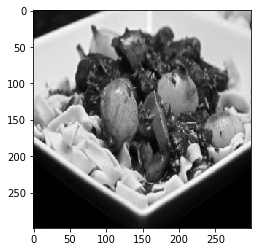

In [ ]:
# Checking out one picture in gray
import re
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

size =299
IMG_size =size
for img,label in zip(sorted_aphanumeric(os.listdir(path_train)),labels):
    img_array = cv2.imread(os.path.join(path_train,img),cv2.IMREAD_GRAYSCALE )    #
    img_array = cv2.resize(img_array,(IMG_size,IMG_size))  
    plt.imshow(img_array,cmap = "gray")
    plt.show()
    break

In [ ]:
# When not using ext.  and using the newest version of keras: 
'''
# convert labels to string from here on: 
labels["label"]=labels["label"].astype(str)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=labels,
    x_col="img_name",
    y_col="label",
    directory=path_train,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = 1,  # set to 1 if u want to use it as a test set.
    class_mode="categorical",
    subset='validation',seed=5) # set as training dat
    '''


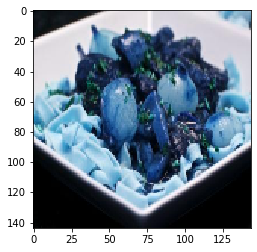

In [ ]:
# Checking out one picture in gray
import re
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

size =144
IMG_size =size
for img,label in zip(sorted_aphanumeric(os.listdir(path_train)),labels):
    img_array = cv2.imread(os.path.join(path_train,img),cv2.COLOR_BGR2RGB)    #
    img_array = cv2.resize(img_array,(IMG_size,IMG_size))  
    plt.imshow(img_array) #,cmap = "gray"
    plt.show()
    break

In [ ]:
# READING IMAGES     , this code is for gray-scale using cv2, but it takes too long.
def transform_images_matrix(labels = labels['label'].index, path = path_train,size = IMG_size):
    # sorting images
    #reading 
    training_data = []
     # you can change this 
    IMG_size = size
    for img,label in zip(sorted_aphanumeric(os.listdir(path_train)),labels):
        #print(img)
        #print(label)
        try:
            img_array = cv2.imread(os.path.join(path_train,img), cv2.IMREAD_GRAYSCALE)
            img_array = cv2.resize(img_array,(IMG_size,IMG_size))  
            training_data.append([img_array,label])
        except Exception as e:
            pass
  #  plt.imshow(img_array,cmap = "gray")
   # plt.show()
    return training_data

In [ ]:
#SAVING DATA
'''
# training_data = transform_images_matrix()
# Save data
pickle_out = open("processed_train_set.pickle","wb")
pickle.dump(training_data, pickle_out)
pickle_out.close()
'''

'\n# training_data = transform_images_matrix()\n# Save data\npickle_out = open("processed_train_set.pickle","wb")\npickle.dump(training_data, pickle_out)\npickle_out.close()\n'

In [ ]:
#  REAIDING IMAGES Nathalie :
'''
labels = pd.read_csv(path)
path_train = "/kaggle/input/food-recognition-challenge/train_set/train_set"
train_dir = path_train
train_sep_dir = 'train_sep/'

if not os.path.exists(train_sep_dir ):
    os.mkdir(train_sep_dir)

for filename, class_name in labels.values:
    if not os.path.exists( train_sep_dir + str(class_name)):
        os.mkdir(train_sep_dir + str(class_name))
    src_path = train_dir + filename
    dst_path = train_sep_dir + str(class_name) + '/' + filename
    try:
        shutil.copy(src_path,dst_path)
    except IOError as e:
        print('Unable to copy file {} to {}'.format(src_path,dst_path))
    except: 
        print('When try copy file {} to {}, unexpected error: {}'.format(src_path,dst_path, sys.exc_info()))
        '''

In [ ]:
sample_csv = pd.read_csv('sample.csv',dtype=str)
test_generator = ImageDataGenerator().flow_from_dataframe(   #preprocessing_function=preprocess_input_vgg)
    dataframe= sample_csv,
    x_col="img_name",
    y_col="label",
    directory=path_test,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False,
    class_mode=None,
    batch_size=BATCH_SIZE)

Found 7653 validated image filenames.


In [ ]:
test_generator.classes_indices

AttributeError: ignored